In [1198]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Delaunay

## Functions

In [1199]:
# Helper function to rotate feature kernel
def rotate_point(origin, point, angle):

    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)

    return int(qx), int(qy)

# Node detection kernel, generates feature to detect inside sliding window
def generate_features(win, feature, angle=0, thickness=1):

    # Check that feature is correctly specified
    assert feature in ("cross", "tee", "elbow", "end"), "Feature must be one of 'cross', 'tee', 'elbow', or 'end'."

    # Convert angle to radians
    angle = np.deg2rad(angle)
    
    # Create kernel matrix, if end feature is selected, generate end-detector mask
    kernel = np.zeros((win, win), np.uint8)
    if feature == "end":
        end_mask = np.zeros((win, win), np.uint8)

    # Define center of kernel
    center = win // 2
    origin = (center, center)

    # Draw Top
    if feature in ("cross", "tee", "end", "elbow"):
        endpoint = rotate_point(origin, (center, -10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Bottom
    if feature == "cross":
        endpoint = rotate_point(origin, (center, win+10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Left 
    if feature in ("cross", "tee"):
        endpoint = rotate_point(origin, (-10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Right 
    if feature in ("cross", "tee", "elbow"):
        endpoint = rotate_point(origin, (win+10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)

    return kernel

## Generate Search Features

In [1200]:
# Generate features to search for

deg_ii = 10
kernel = 18
thickness = 2
features = []

for theta in range(0, 360, deg_ii):
    feature = generate_features(kernel, feature="end", angle=theta, thickness=thickness)
    features.append(np.asarray(feature))

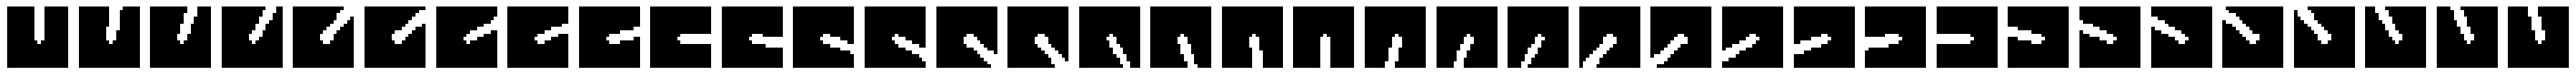

In [1201]:
#Visualize search features
num_features = len(features)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, num_features, figsize=(num_features, 5))

for ii, feature in enumerate(features):
    # Plot image in subplot
    axs[ii].imshow(feature, cmap='gray')
    axs[ii].axis('off')  # Turn off axis


# Show the plot
plt.tight_layout()
plt.show()

## Load and Process Image

In [1202]:
# Load image
image = cv2.imread('test_sequence/image2.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (image.shape[0]//2, image.shape[0]//2))

# Process image to eliminate floating regions
N = 200 # Minimum number of pixels per region

# Threshold and find contours
_, thresh = cv2.threshold(image, 5, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the filtered contours
mask = np.zeros_like(thresh)

# Draw contours for mask
for contour in contours:
    if cv2.contourArea(contour) >= N:
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

# Apply the mask to the original image
img = cv2.bitwise_and(image, image, mask=mask)

# Threshold image
_, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
img = img.astype(np.uint8)*255

## Template Matching

In [1203]:
# Find features via template matching

knots = []

for feature in features:
    template = feature * np.max(img)

    # Apply template Matching
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    threshold = 0.65
    loc = np.where( res >= threshold)
    if len(loc[0]) > 0:
        knots.append(loc)

# Flatten and pair up point values
knots = [(x, y) for arr1, arr2 in knots for x, y in zip(arr1, arr2)]
len(knots)

1973

## Filter Points

In [1204]:
# Filter out too-similar points in the array
occurrences = {}
filtered_rows = []

# Iterate over each row in the array
for row in knots:
    # Check if either value in the row has not been seen before
    if occurrences.get(row[0], 0) < 1 and occurrences.get(row[1], 0) < 1:
        # Add the row to the filtered list
        filtered_rows.append(row)
        # Increment the occurrence count for both elements
        occurrences[row[0]] = occurrences.get(row[0], 0) + 1
        occurrences[row[1]] = occurrences.get(row[1], 0) + 1

knots = filtered_rows

# Remove any near-duplicate rows

# Similarity threshold
threshold = 10

# Function to check if two rows are similar
def is_similar(row1, row2, thresh):
    row1 = np.asarray(row1)
    row2 = np.asarray(row2)

    return np.all(np.abs(row1 - row2) < thresh)

# Function to remove similar rows
def remove_similar_rows(arr, thresh):
    unique_rows = []

    for current_row in arr:
        # Check if the current row is similar to any already added row
        if not any(is_similar(current_row, unique_row, thresh) for unique_row in unique_rows):
            unique_rows.append(current_row)

    return np.array(unique_rows)


# Process the array
knots = remove_similar_rows(knots, threshold)
print(len(knots))

87


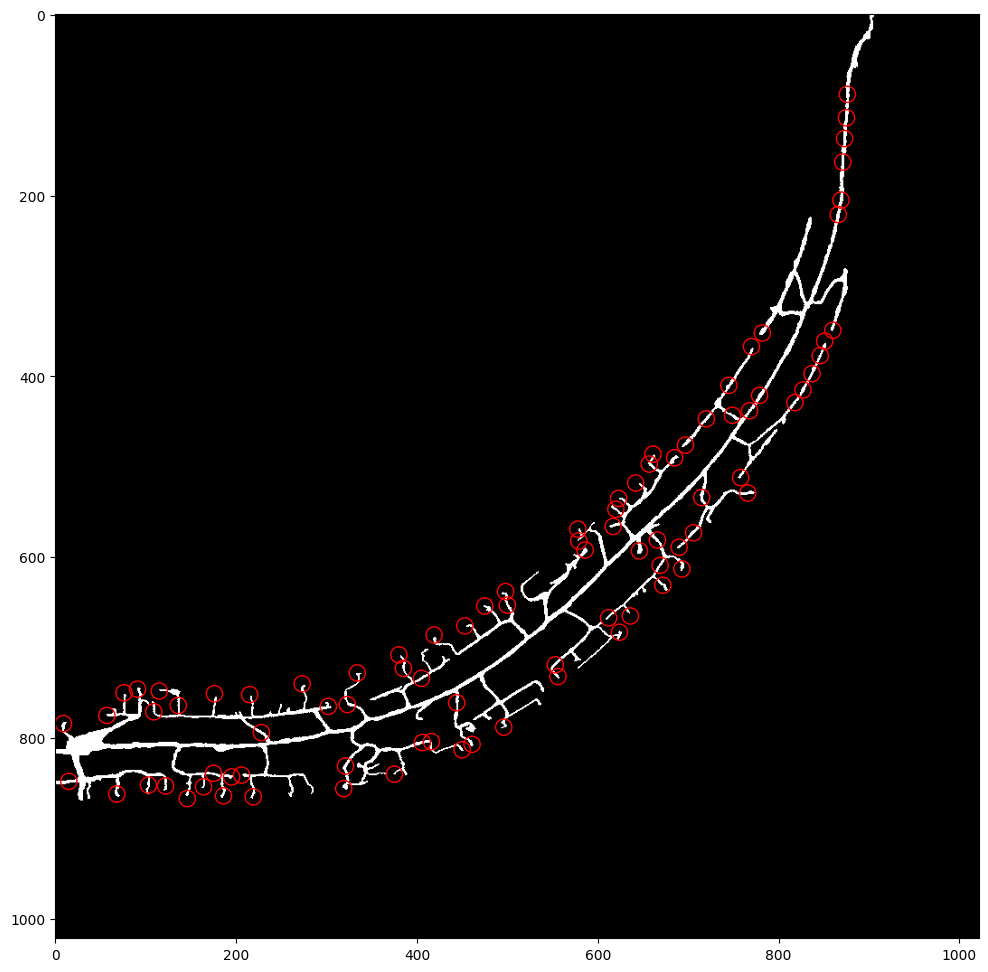

In [1205]:
# Plot Vertices on image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, cmap='gray')

# Get template matching offsets
w, h = template.shape[::-1]

# Adding circles at each knot
for xi, yi in knots:
    circle = Circle((yi+w//2, xi+h//2,), radius=(kernel//2), fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(circle)

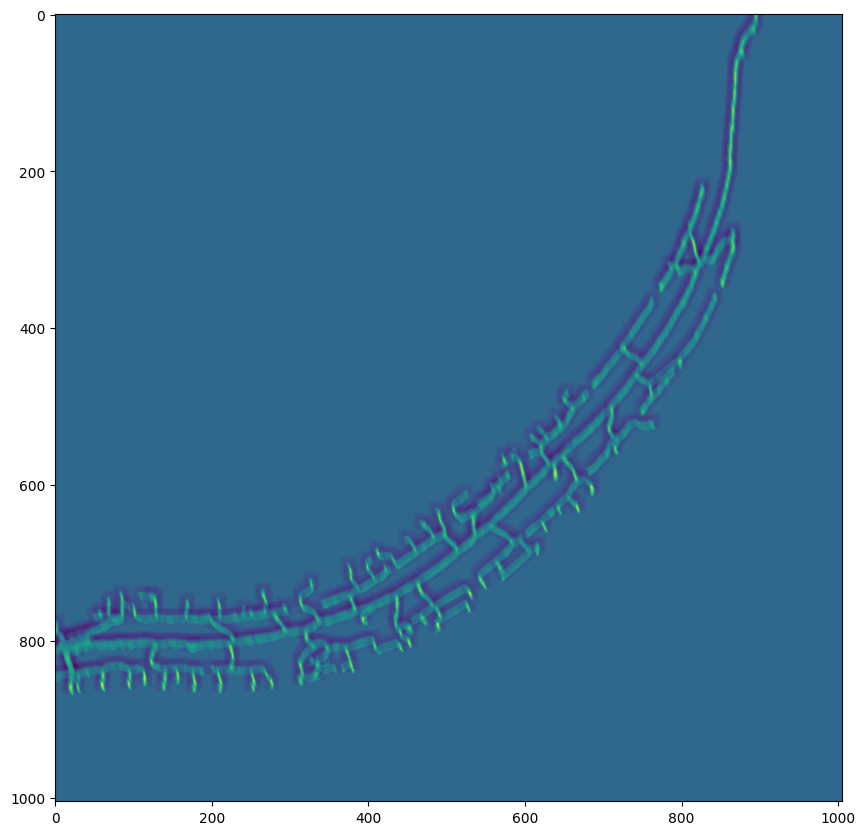

In [1206]:
# Plot Template match image
fig, ax = plt.subplots(figsize=(img.shape[0]/100, img.shape[0]/100))
ax.imshow(res)

In [1207]:
# Draw Border Grid
grid_w = image.shape[0]
grid_h = image.shape[0]
grid = np.ndarray([1,2])

for ii in range(0, grid_w, grid_w//10):
    for jj in range(0, grid_h, grid_h//10):
        knots = np.append(knots, [[ii, jj]], axis=0)
        #print(f"{ii}, {jj}")

    

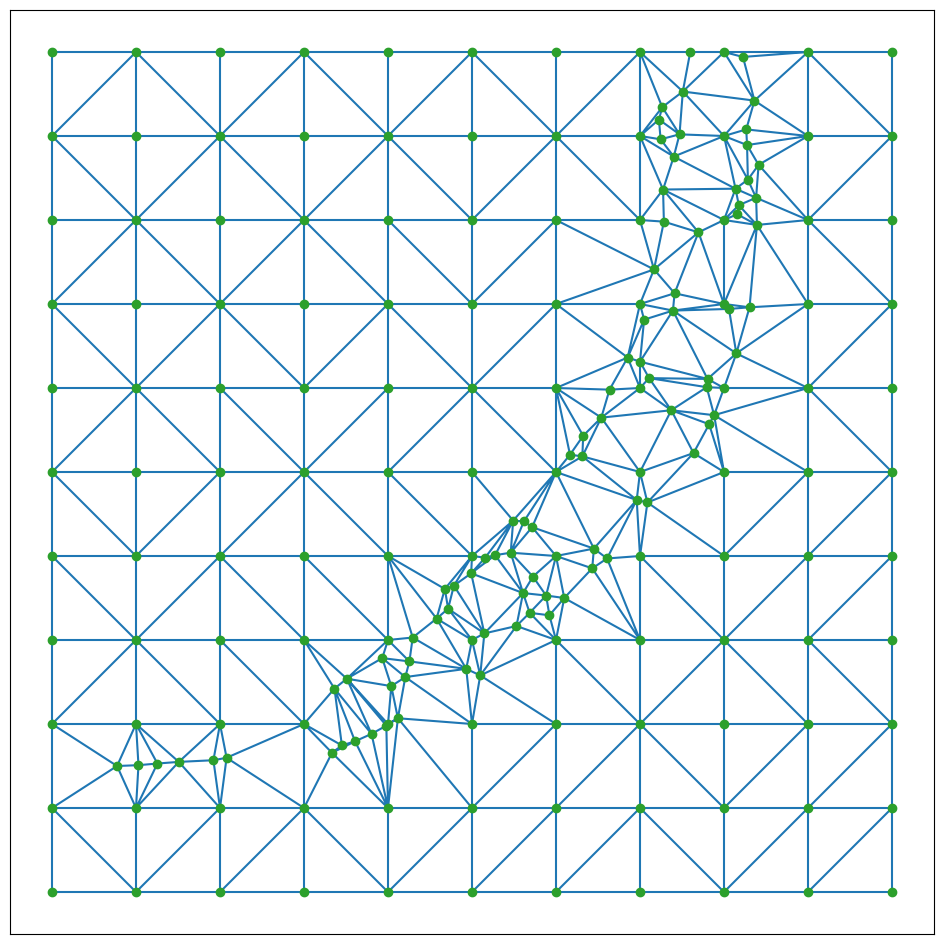

In [1208]:
delaunay = Delaunay(knots)

plt.figure(figsize=(12, 12))
plt.triplot(knots[:, 0], -knots[:, 1], delaunay.simplices)
plt.plot(knots[:, 0], -knots[:, 1], 'o')

plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([])
plt.yticks([])

plt.show()